# GOOGL stock 'Close' value prediction

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import pandas_datareader.data as web
from talib.abstract import *
import quandl
from sklearn.preprocessing import MinMaxScaler

In [30]:
def datadownload(stocks):
    try:
        print("Doenloading data")
        quandl.ApiConfig.api_key = 'WX8iXr2gmxoLnpGdxysa'
        data = quandl.get_table('WIKI/PRICES', ticker = stocks)
        
    except (RuntimeError, TypeError, NameError,Exception):
                   print("Oops! Quandl Data Service is not working ....")
                   print("Data Taken from last updated repository")
#                    dow=pd.read_csv("AllDJIdata.csv")
        
    
    return data

In [31]:
def get_indicators(stocks, period):
#     for i in stocks:
        print("***********************************************************************")
        stocks.columns = [s.lower() for s in stocks.columns]
        print("Adding Features: Started  ")
        features = pd.DataFrame(SMA(stocks, timeperiod=10))
        features.columns = ['sma_10']
        features['NATR']=pd.DataFrame(NATR(stocks, timeperiod=14))
        features = pd.concat([features,STOCHF(stocks, fastk_period=14, fastd_period=3)], axis=1)
        features['willr'] = pd.DataFrame(WILLR(stocks, timeperiod=14))
        features['rsi'] = pd.DataFrame(RSI(stocks, timeperiod=14))
        features['wma_10'] = pd.DataFrame(WMA(stocks,10))
        features['T3'] =pd.DataFrame(T3(stocks, timeperiod=5, vfactor=0))
#         features['closePrice']=pd.DataFrame(stocks['close'].shift(-period))
        features['return_pct_change'] = ROC(stocks, timeperiod=period)
        features['return_pct_change'] = features['return_pct_change'].shift(-period)
        features['pct_change'] = features['return_pct_change'].apply(lambda x: '1' if x > 0 else '0' if x <= 0 else np.nan)
        features['closePrice']=pd.DataFrame(stocks['close'].shift(-period))
        features = features.dropna()
        return features

In [32]:
# stocks='GOOGL'
# stocks='^DJI'
stocks="AAPL"

stockdata = datadownload(stocks)
delist = ['ticker','ex-dividend','split_ratio','adj_open','adj_high','adj_low','adj_close','adj_volume']
stockdata.drop(delist,axis =1,inplace=True)
stockdata.index = stockdata['date']
stockdata.drop('date',axis=1,inplace=True)

## SAve the File 
today = datetime.date.today()
# file_name = stocks+'_data_%s.csv' % today
# stockdata.to_csv(file_name)
# stockdata=pd.read_csv("AllDJIdata.csv")
stockdataupdated = get_indicators(stockdata,1)


Doenloading data
***********************************************************************
Adding Features: Started  


In [33]:


stockdataupdated.head()
# stockdataupdated['']

,sma_10,NATR,fastk,fastd,willr,rsi,wma_10,T3,return_pct_change,pct_change,closePrice
date,,,,,,,,,,,
1981-01-19,31.313,3.483626,52.400000,27.387302,-47.600000,59.352320,31.372545,31.617967,-3.011865,0,31.88
1981-01-20,31.276,3.557063,36.222222,33.792441,-63.777778,55.393142,31.475636,31.598849,1.944793,1,32.50
1981-01-21,31.438,3.431185,50.000000,46.207407,-50.000000,57.313571,31.698182,31.635213,1.138462,1,32.87
1981-01-22,31.700,3.287139,72.375691,52.865971,-27.624309,58.462857,31.958545,31.724322,-0.365075,0,32.75
1981-01-23,31.787,3.118053,86.805556,69.727082,-13.194444,57.918207,32.149455,31.843945,-1.526718,0,32.25


In [9]:
# stockdata.index = stockdata['Date']
# delist = ['Date','Adj Close','Volume']
# stockdata.drop(delist,axis=1,inplace=True)
# stockdata.head()
# stockdataupdated = stockdata

In [6]:
# inverted_X = scaler.inverse_transform(scaled_stock)

In [34]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [35]:
X_train, y_train, X_test, y_test = load_data(stockdataupdated[::-1], 7)

In [36]:
def build_model(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['mape','mae'])
        return model

## Setting X and Y for training and testing

In [37]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (8294, 7, 11))
('y_train', (8294,))
('X_test', (922, 7, 11))
('y_test', (922,))


## Loading the model sequence structure

In [38]:
model = build_model([11,7,1])

## Executing the model & RMS/RMSE results

In [39]:
y_train

array([160.08, 156.39, 155.57, ..., 27.62, 28.62, 27.87], dtype=object)

In [40]:
starttime= time.time()
history = model.fit(X_train,y_train,batch_size=512,epochs=200,validation_split=0.1,verbose=0)
print("Time Taken to Model %s seconds ---" % (time.time() - starttime))

Time Taken to Model 556.123813868 seconds ---


## Building model functions

In [47]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 16.51 MSE (4.06 RMSE)
Test Score: 1.11 MSE (1.05 RMSE)


In [48]:
historydf = pd.DataFrame(history.history)
mae = pd.DataFrame(historydf['mean_absolute_error'].tail(1))
mape = pd.DataFrame(historydf['mean_absolute_percentage_error'].tail(1))
vmape = pd.DataFrame(historydf['val_mean_absolute_percentage_error'].tail(1))
vmae = pd.DataFrame(historydf['val_mean_absolute_error'].tail(1))


In [49]:
finalreport = pd.DataFrame(mape)
finalreport.columns = ['MAPE']
finalreport['MAE']=mae
finalreport

,MAPE,MAE
199,6.732417,6.94891


In [50]:
p = model.predict(X_test)

## Predictions vs Real results

In [51]:
p

array([[ 27.32431984],
       [ 26.57919884],
       [ 26.28338623],
       [ 26.10647011],
       [ 26.86354256],
       [ 26.29868507],
       [ 26.60928154],
       [ 26.64282227],
       [ 26.72668648],
       [ 26.61541939],
       [ 26.76298332],
       [ 27.09885788],
       [ 26.9609375 ],
       [ 27.19263077],
       [ 27.31738472],
       [ 27.16137505],
       [ 27.75499153],
       [ 27.37612724],
       [ 27.25136757],
       [ 27.88114738],
       [ 27.39975357],
       [ 28.67552376],
       [ 29.99086189],
       [ 28.32718658],
       [ 29.73309326],
       [ 28.66285515],
       [ 29.1607666 ],
       [ 28.49006462],
       [ 27.95249748],
       [ 26.18383026],
       [ 26.82631302],
       [ 25.79125404],
       [ 26.23866272],
       [ 28.44948387],
       [ 28.77510262],
       [ 28.83120537],
       [ 26.85140419],
       [ 26.01966858],
       [ 25.53646278],
       [ 26.73017693],
       [ 25.80228233],
       [ 25.80719185],
       [ 26.30123711],
       [ 26

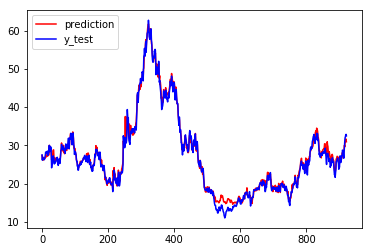

In [52]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()